# Assignment

***Submit any final predictions to our Kaggle challenge!***

If your Kaggle Public Leaderboard score is:
- **Nonexistent**: You need to work on your model and submit predictions
- **< 70%**: You should work on your model and submit predictions
- **70% < score < 80%**: You may want to work on visualizations and write a blog post
- **> 80%**: You should work on visualizations and write a blog post

Explore the class_weight demo in this notebook.

Read these articles (if you haven't already)
  - [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
  - [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)

### Stretch Goals

Explore these links!

- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/)

In [63]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

LOCAL = '../data/tanzania/'

train = pd.merge(pd.read_csv(LOCAL + 'train_features.csv'), 
                 pd.read_csv(LOCAL + 'train_labels.csv'))
test = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [136]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

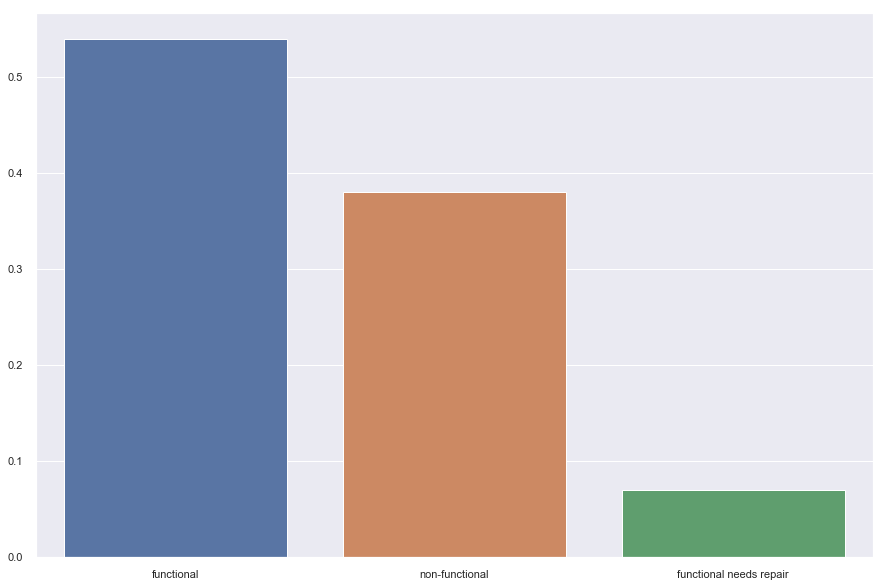

In [140]:
x = ['functional','non-functional','functional needs repair']
y = [0.54,0.38,0.07]
sns_wells = sns.barplot(x,y)
sns.set(rc={'figure.figsize':(15,10)})
sns_wells.figure.savefig("wells.png")

In [64]:
train.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  47520.000000   47520.000000  47520.000000  47520.000000  4.752000e+04   
mean   37037.915699     321.925261    669.567656     34.082431 -5.705946e+00   
std    21412.099719    3197.240487    693.005745      6.552053  2.941332e+00   
min        0.000000       0.000000    -63.000000      0.000000 -1.164944e+01   
25%    18482.750000       0.000000      0.000000     33.092142 -8.528215e+00   
50%    36986.500000       0.000000    372.500000     34.910740 -5.021436e+00   
75%    55450.250000      25.000000   1320.000000     37.170578 -3.327185e+00   
max    74247.000000  350000.000000   2770.000000     40.344301 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  47520.000000  47520.000000   47520.000000  47520.000000   
mean       0.477736     15.258291       5.616751    179.805513   
std       13.312977     17.530228       9.621230    463.081564   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  15300.000000   

       construction_year  
count       47520.000000  
mean         1302.768939  
std           950.955437  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [65]:
import pandas_profiling
train.profile_report()

In [66]:
def wrangle(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    X['construction_year'] = X['construction_year'].replace(0, 1960)
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns=['quantity_group','date_recorded', 'recorded_by', 'id'])
    
    X['years'] = X['year_recorded'] - X['construction_year'] 
    
#     categoricals = X.select_dtypes(exclude='number').columns
#     for col in categoricals:
#         X[col] = X[col].fillna('MISSING')
        
    return X

In [67]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [68]:
train.describe(exclude='number').T.sort_values(by='unique')

count unique                     top   freq
public_meeting         44876      2                    True  40838
permit                 45077      2                    True  31071
status_group           47520      3              functional  25807
source_class           47520      3             groundwater  36638
quantity               47520      5                  enough  26567
management_group       47520      5              user-group  42027
quality_group          47520      6                    good  40598
waterpoint_type_group  47520      6      communal standpipe  27642
source_type            47520      7                  spring  13620
waterpoint_type        47520      7      communal standpipe  22778
payment_type           47520      7               never pay  20287
extraction_type_class  47520      7                 gravity  21448
payment                47520      7               never pay  20287
water_quality          47520      8                    soft  40598
basin                  47520      9           Lake Victoria   8137
source                 47520     10                  spring  13620
scheme_management      44392     12                     VWC  29470
management             47520     12                     vwc  32449
extraction_type_group  47520     13                 gravity  21448
extraction_type        47520     18                 gravity  21448
region                 47520     21                  Iringa   4250
lga                    47520    124                  Njombe   2003
funder                 44616   1716  Government Of Tanzania   7321
installer              44603   1929                     DWE  13978
ward                   47520   2082                   Igosi    257
scheme_name            24988   2563                       K    548
subvillage             47234  17231                 Shuleni    420
wpt_name               47520  30661                    none   2879

In [69]:
train['permit'].value_counts()

True     31071
False    14006
Name: permit, dtype: int64

In [70]:
target = 'status_group'
train_features = train.drop(columns=[target, 'num_private'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features

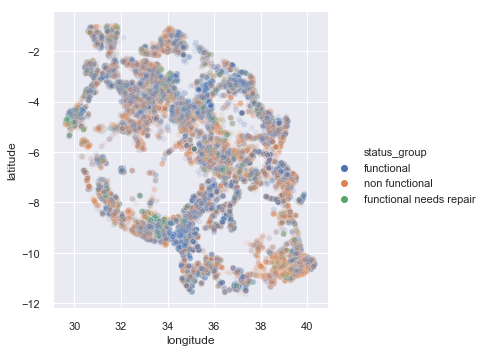

In [71]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

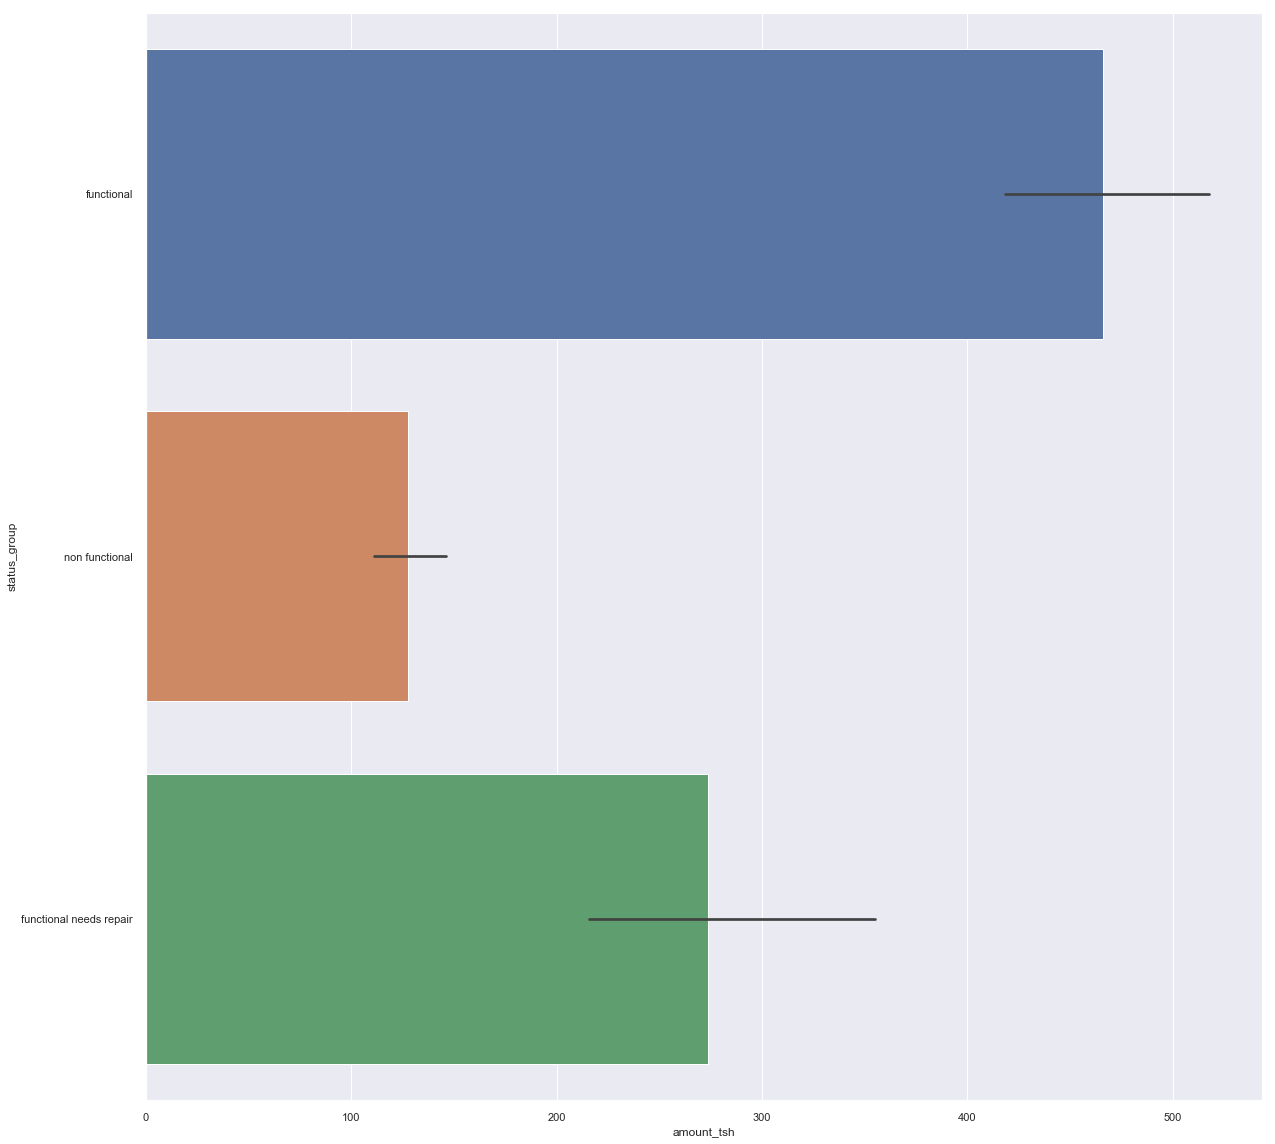

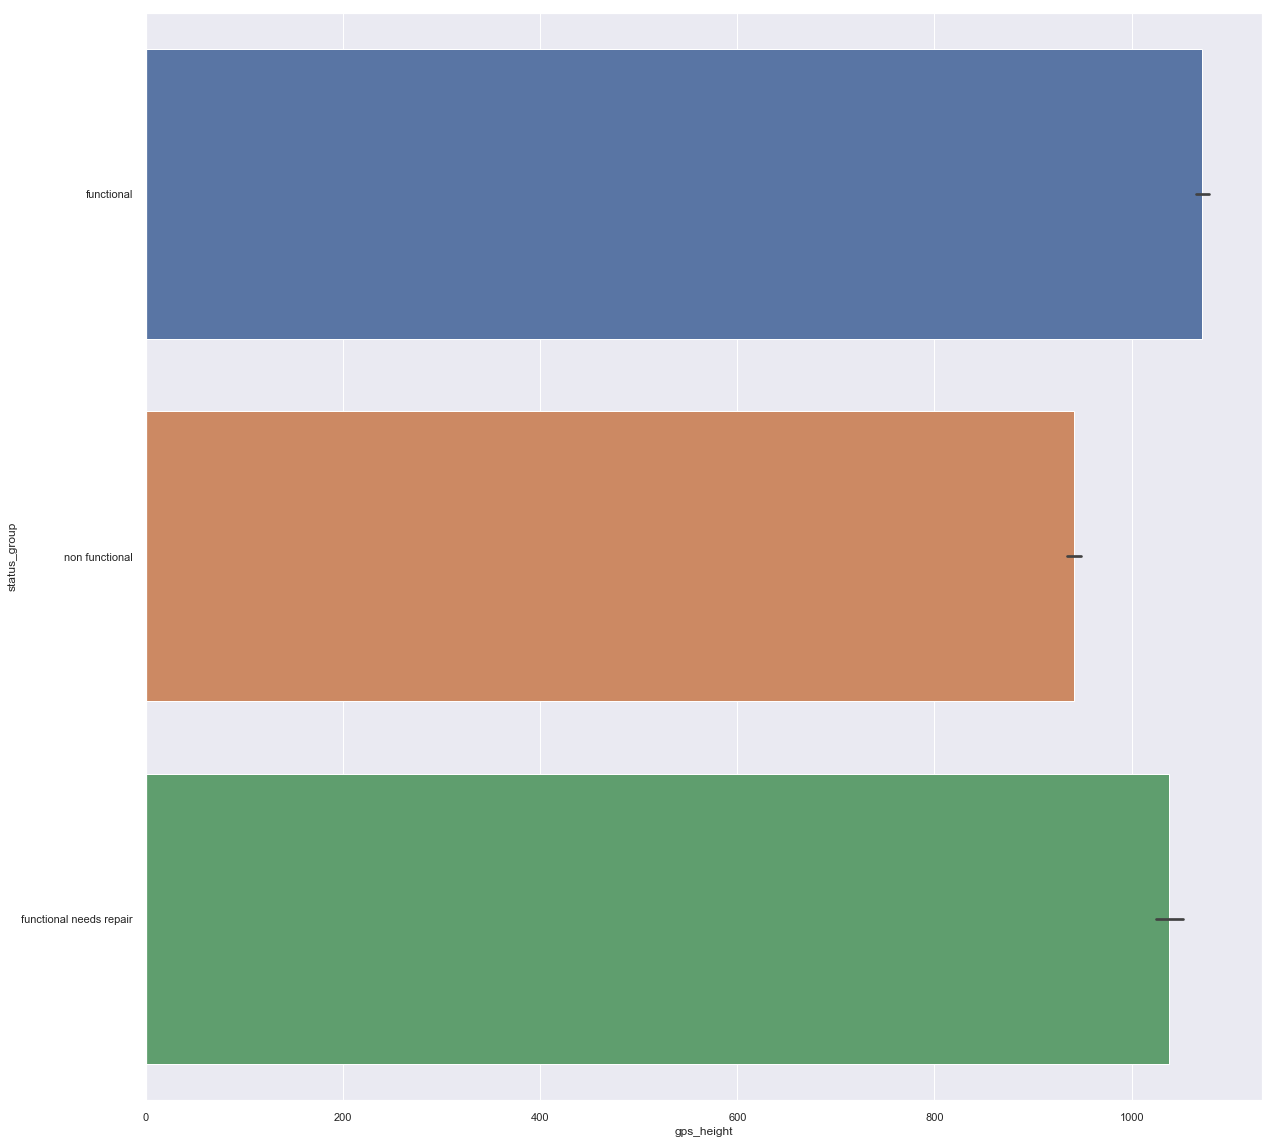

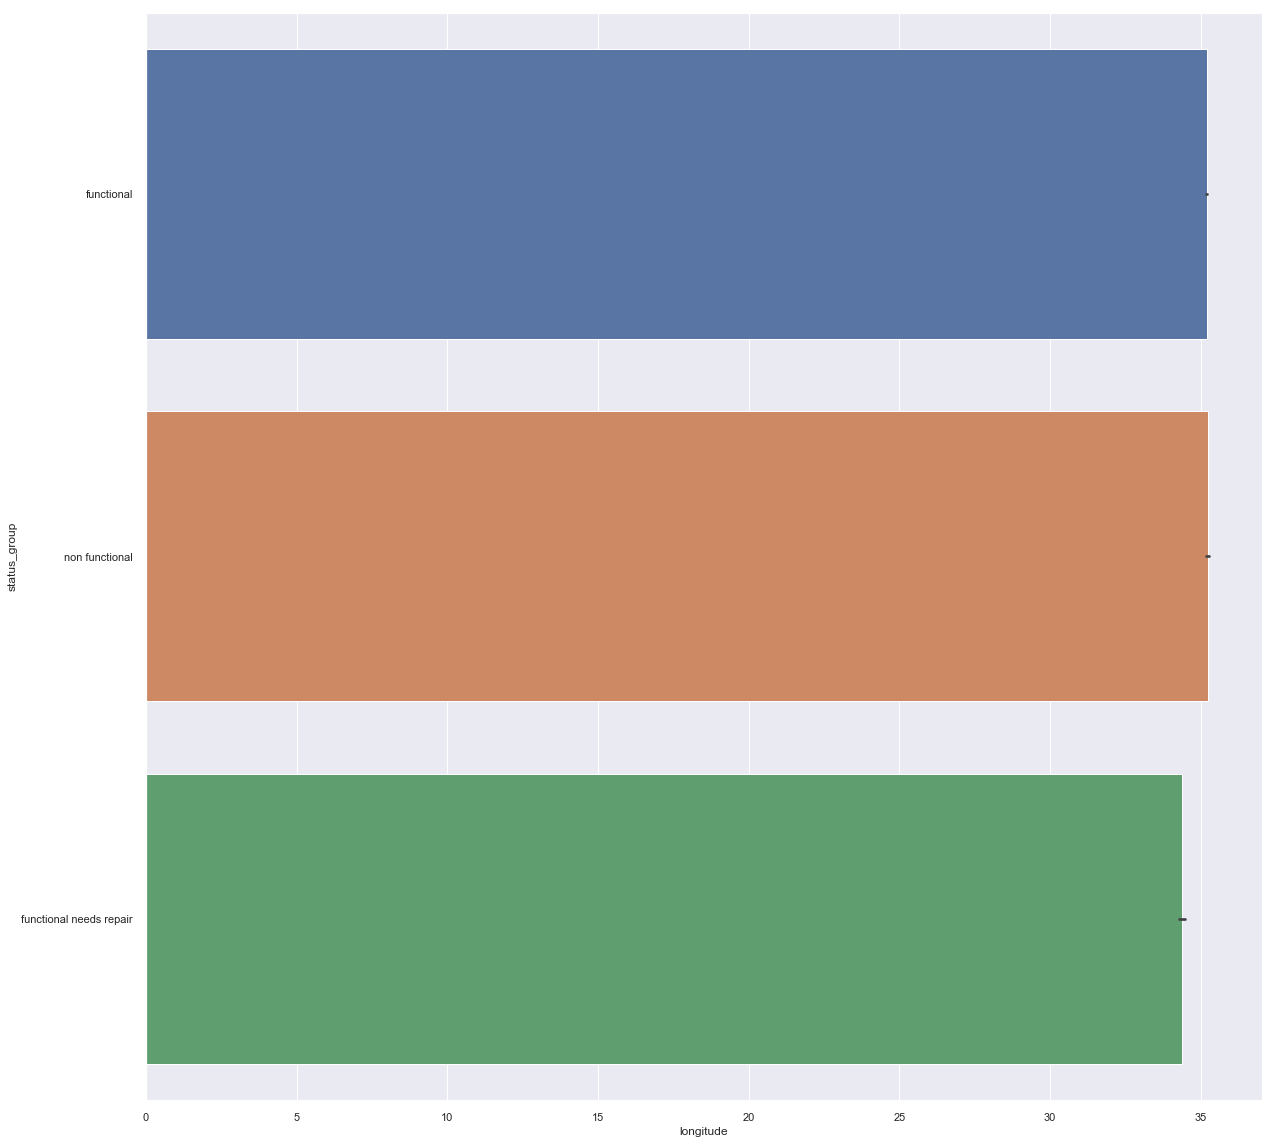

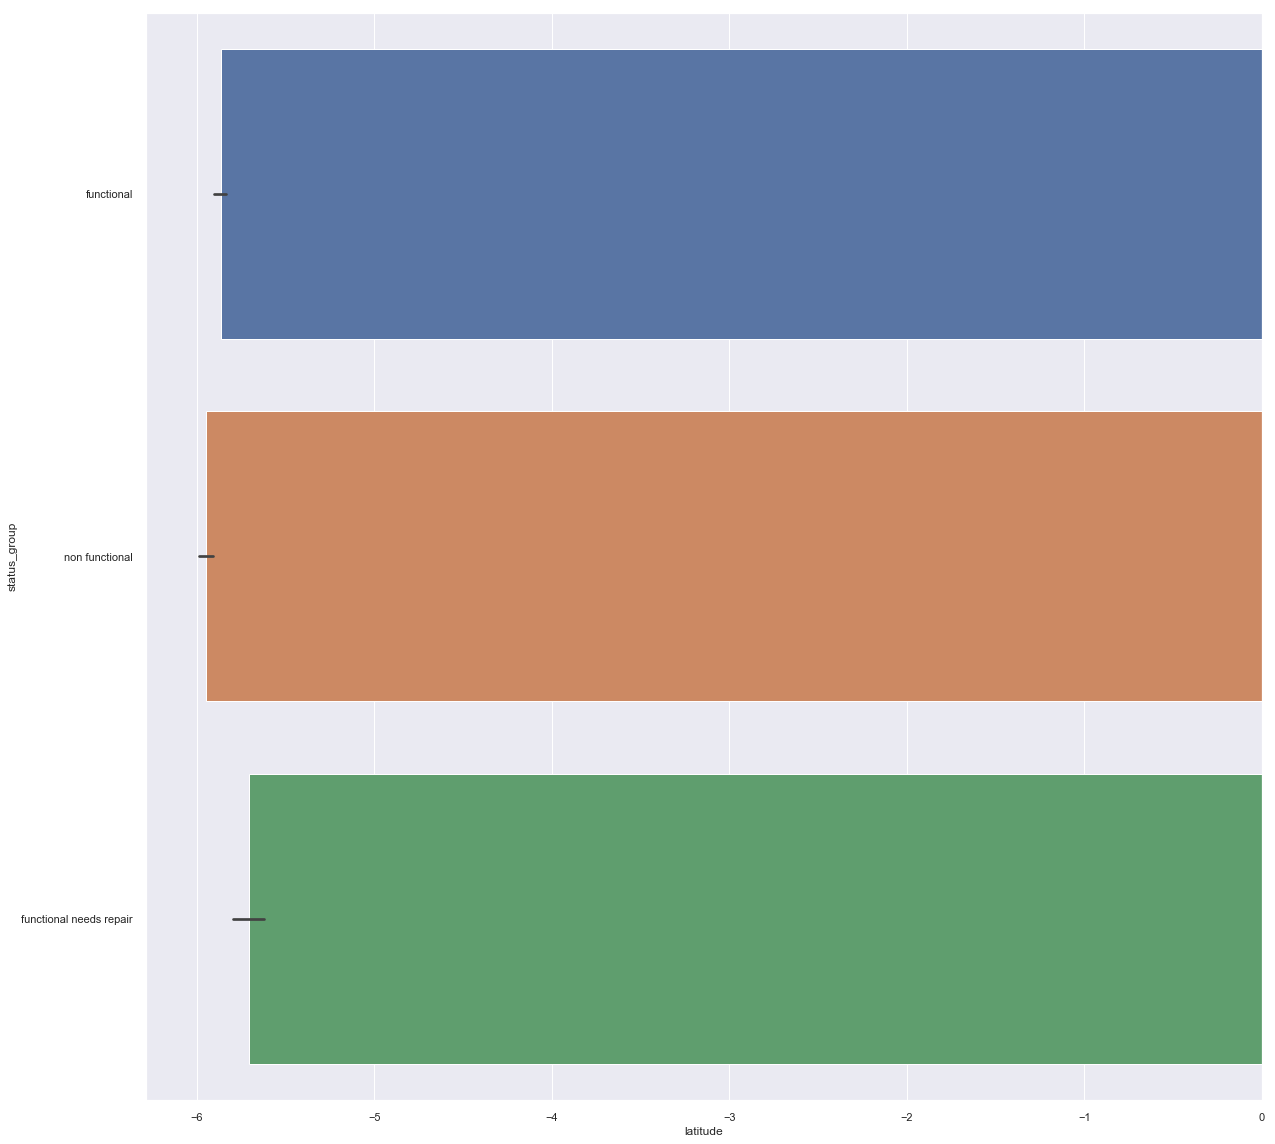

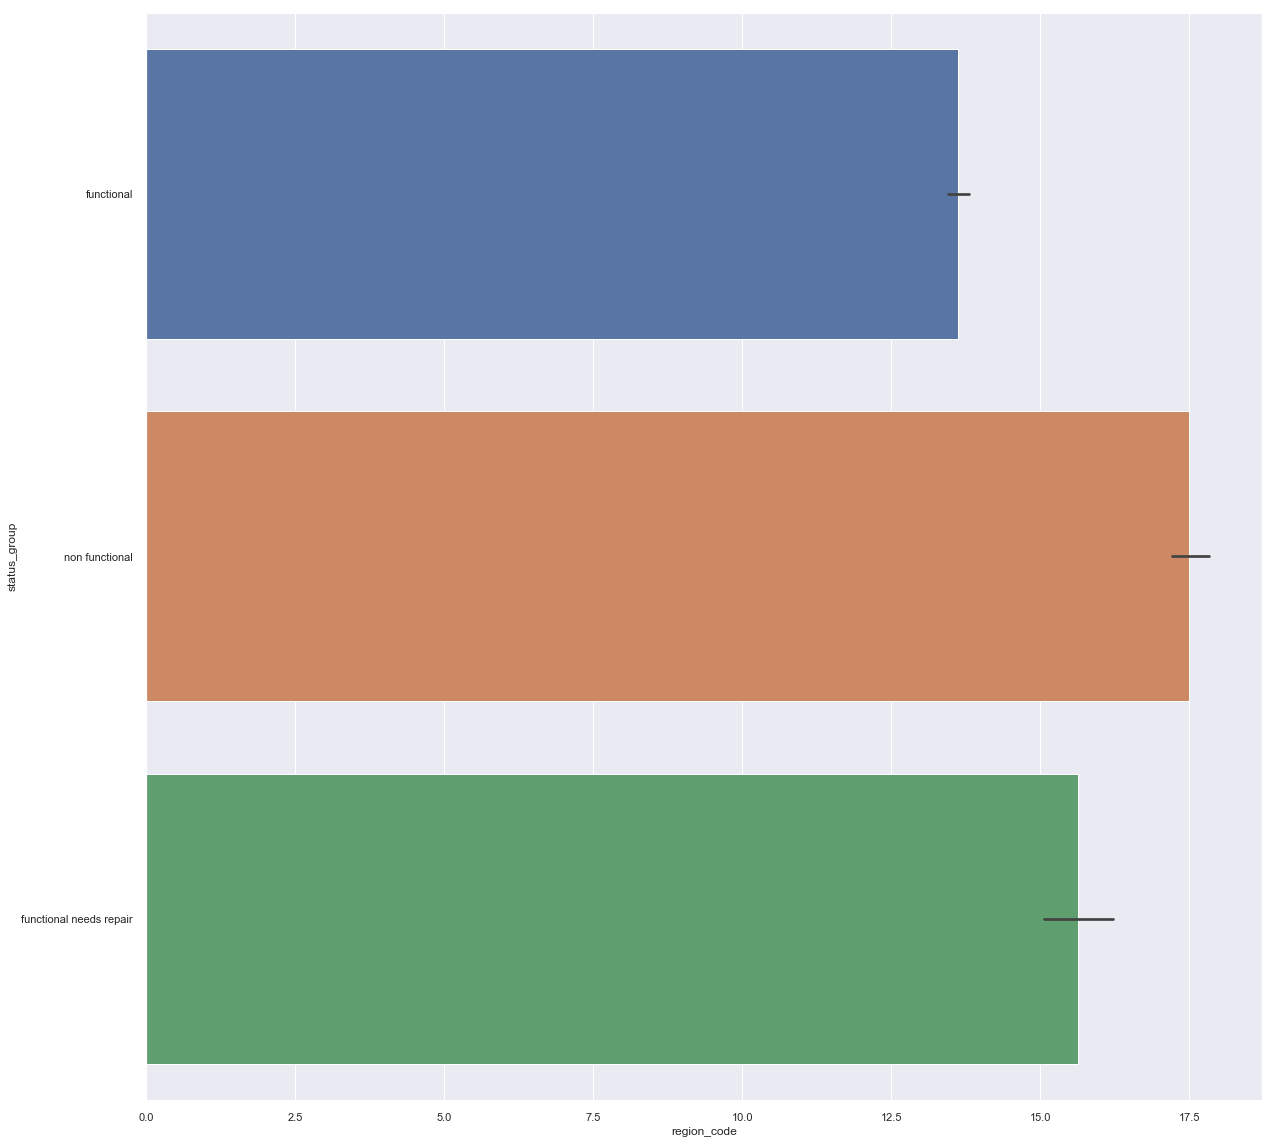

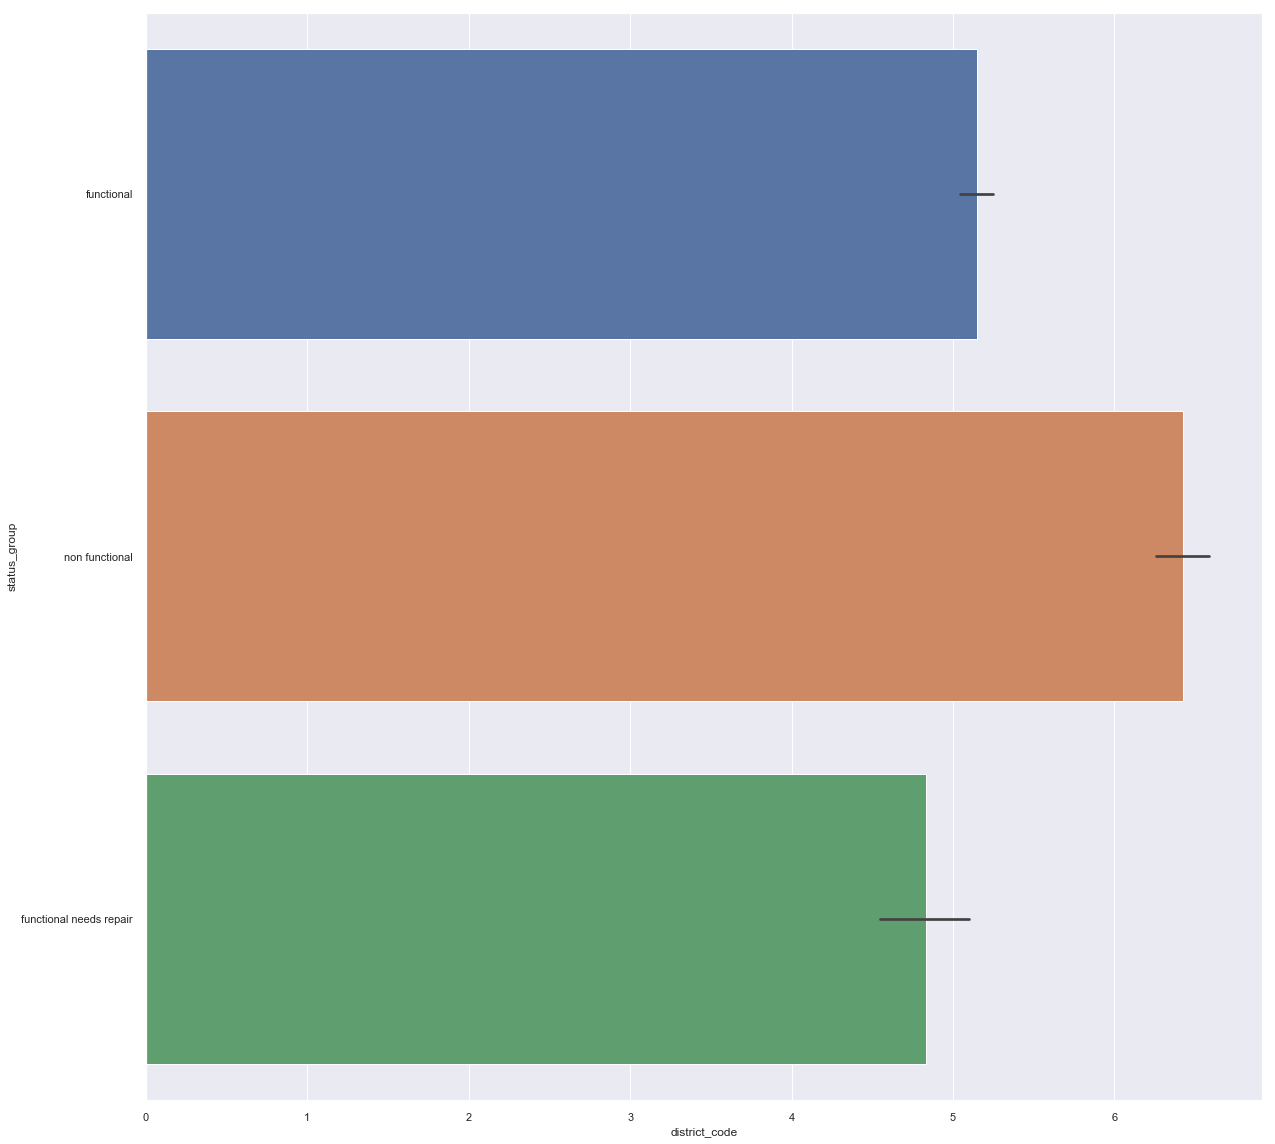

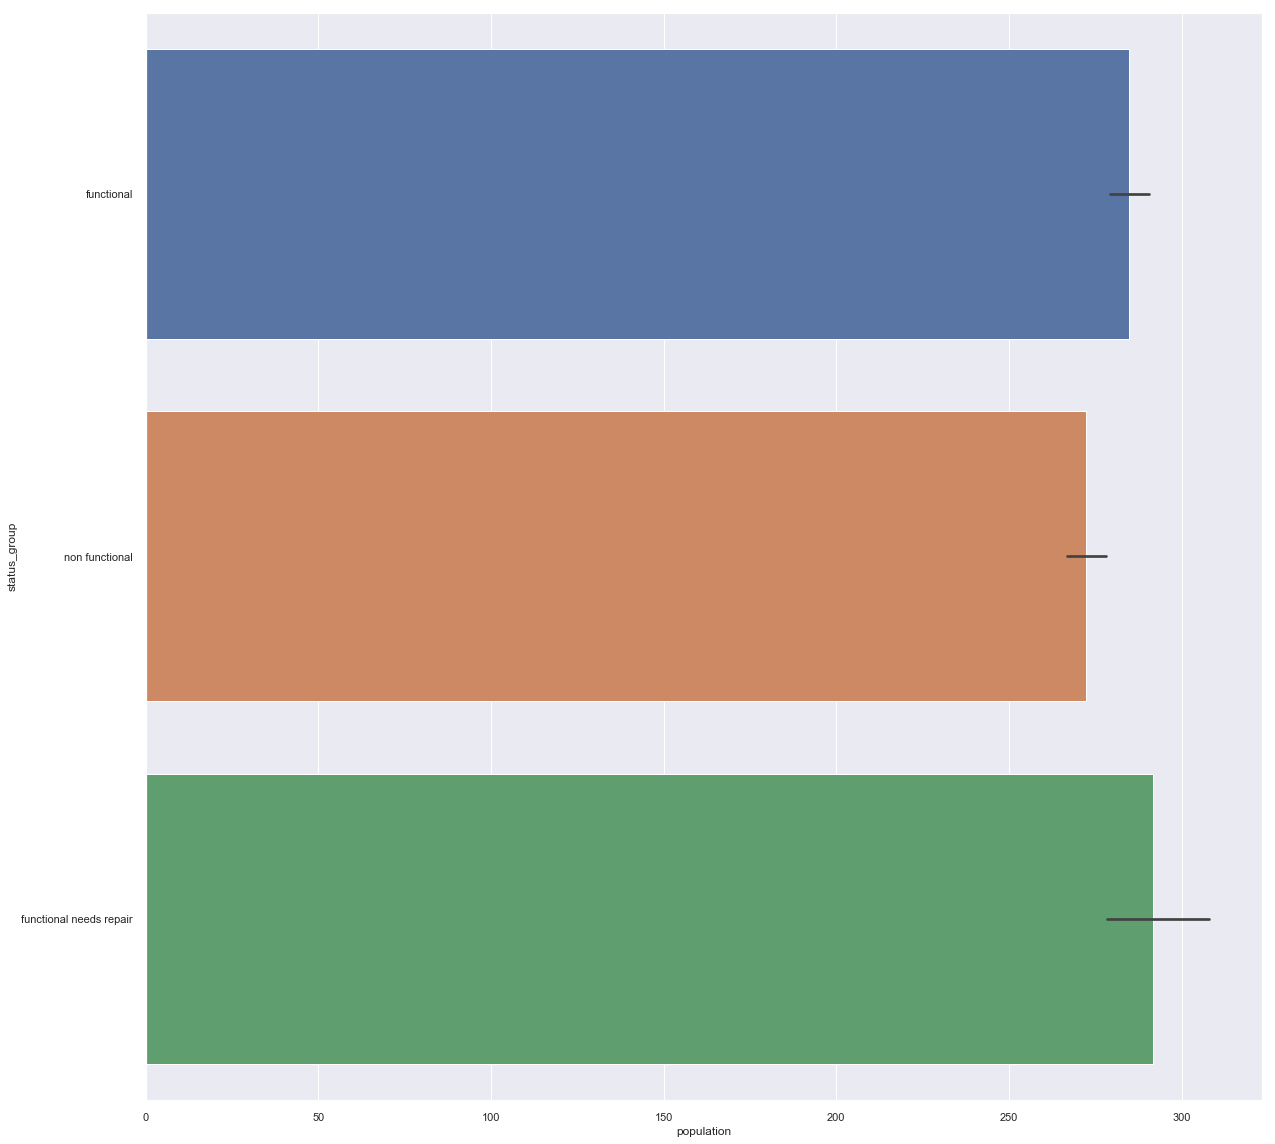

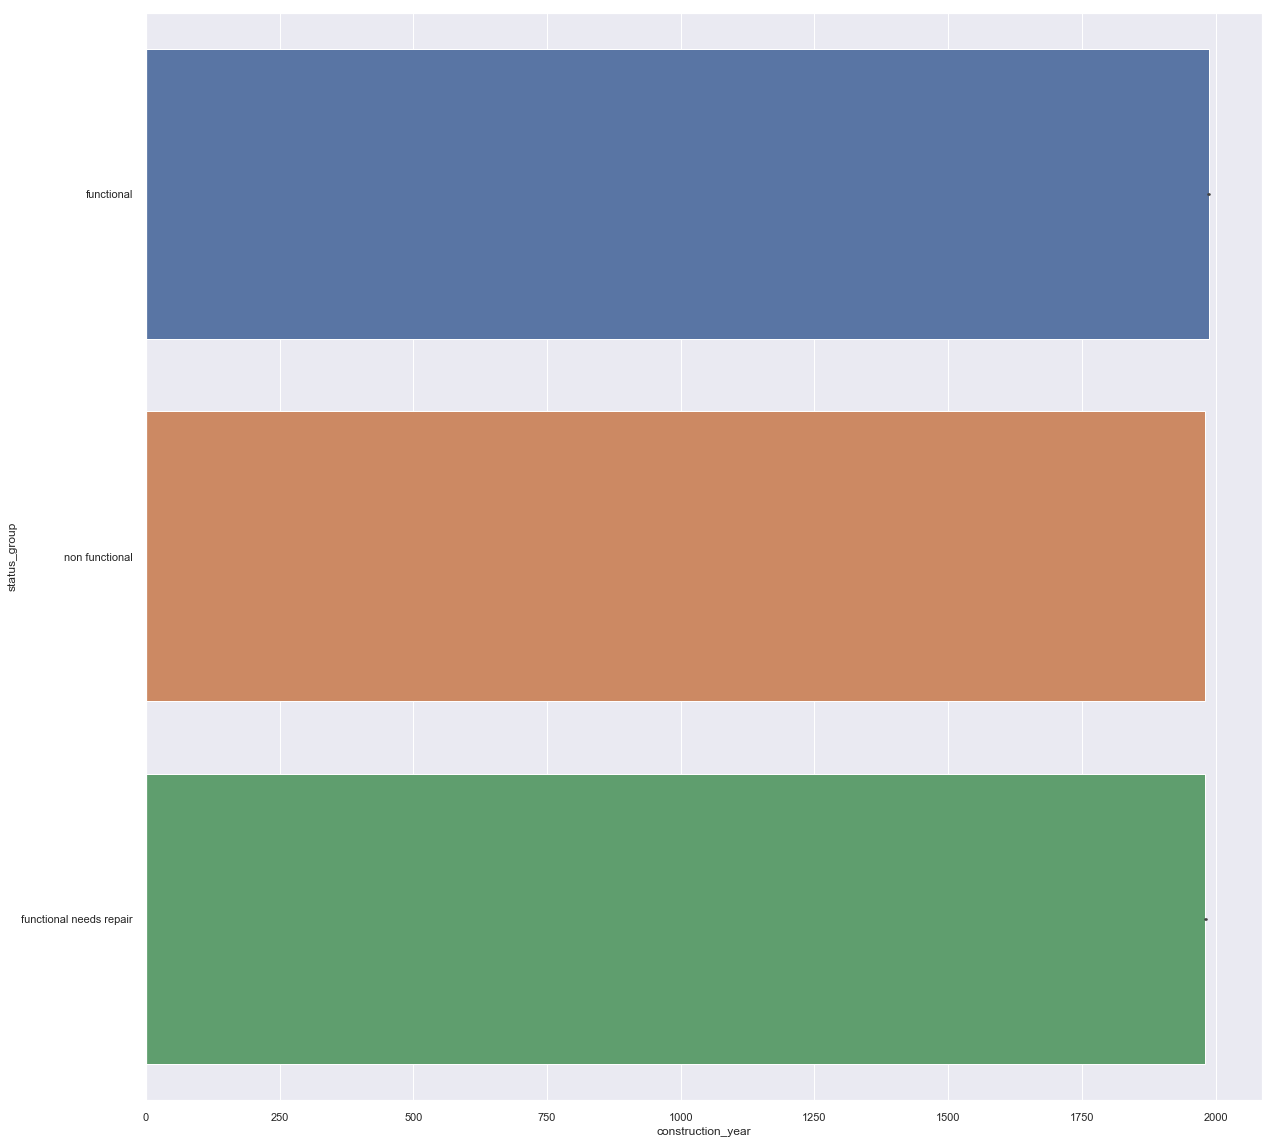

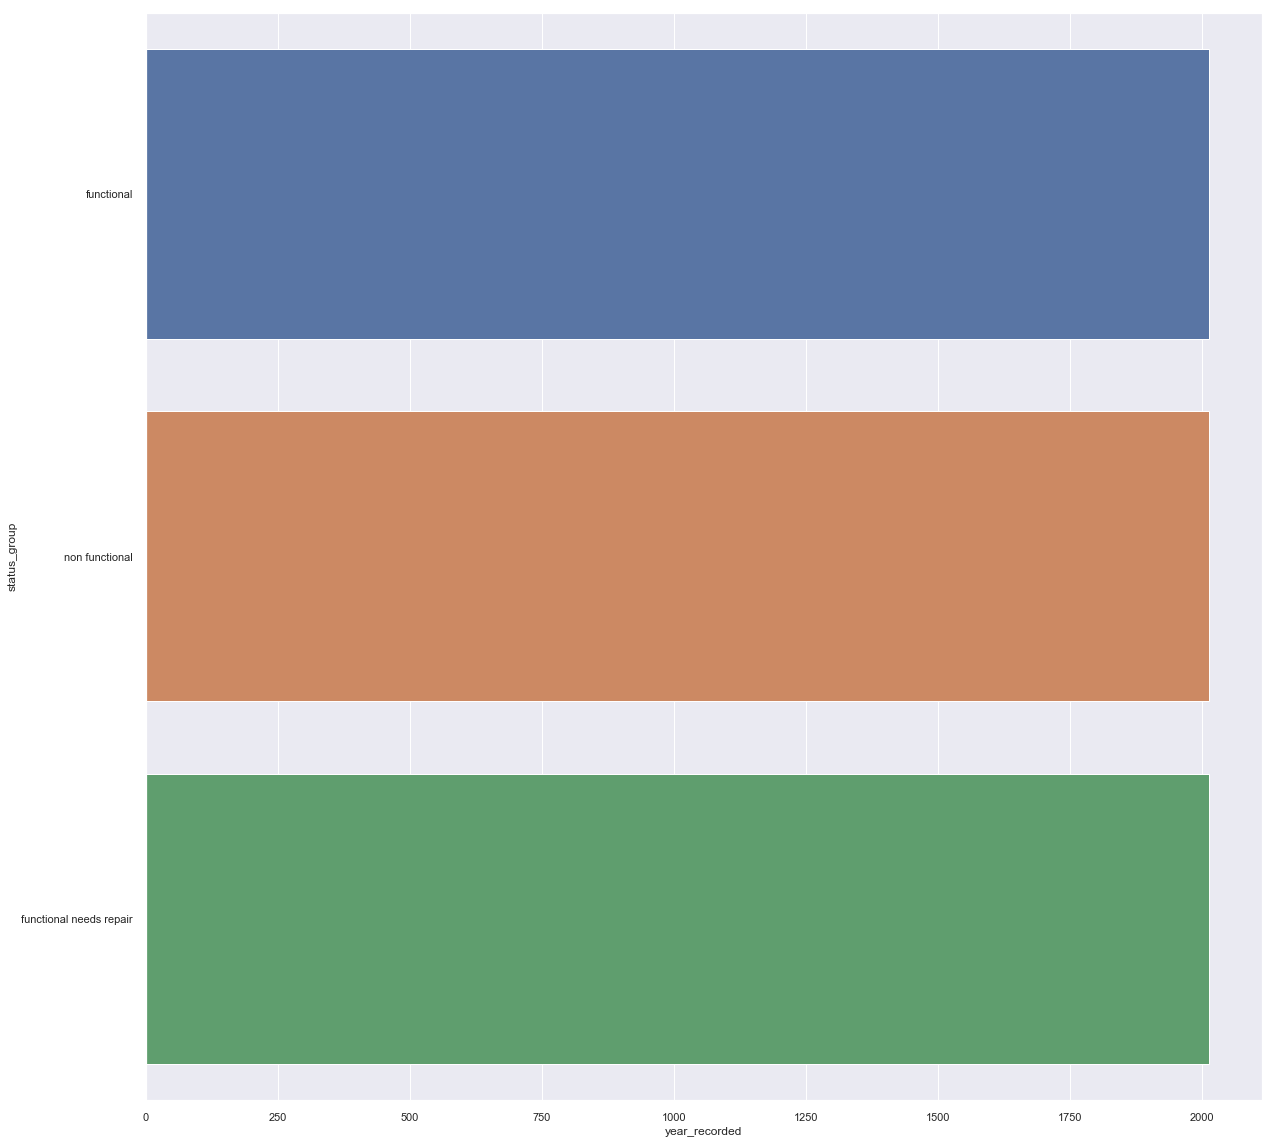

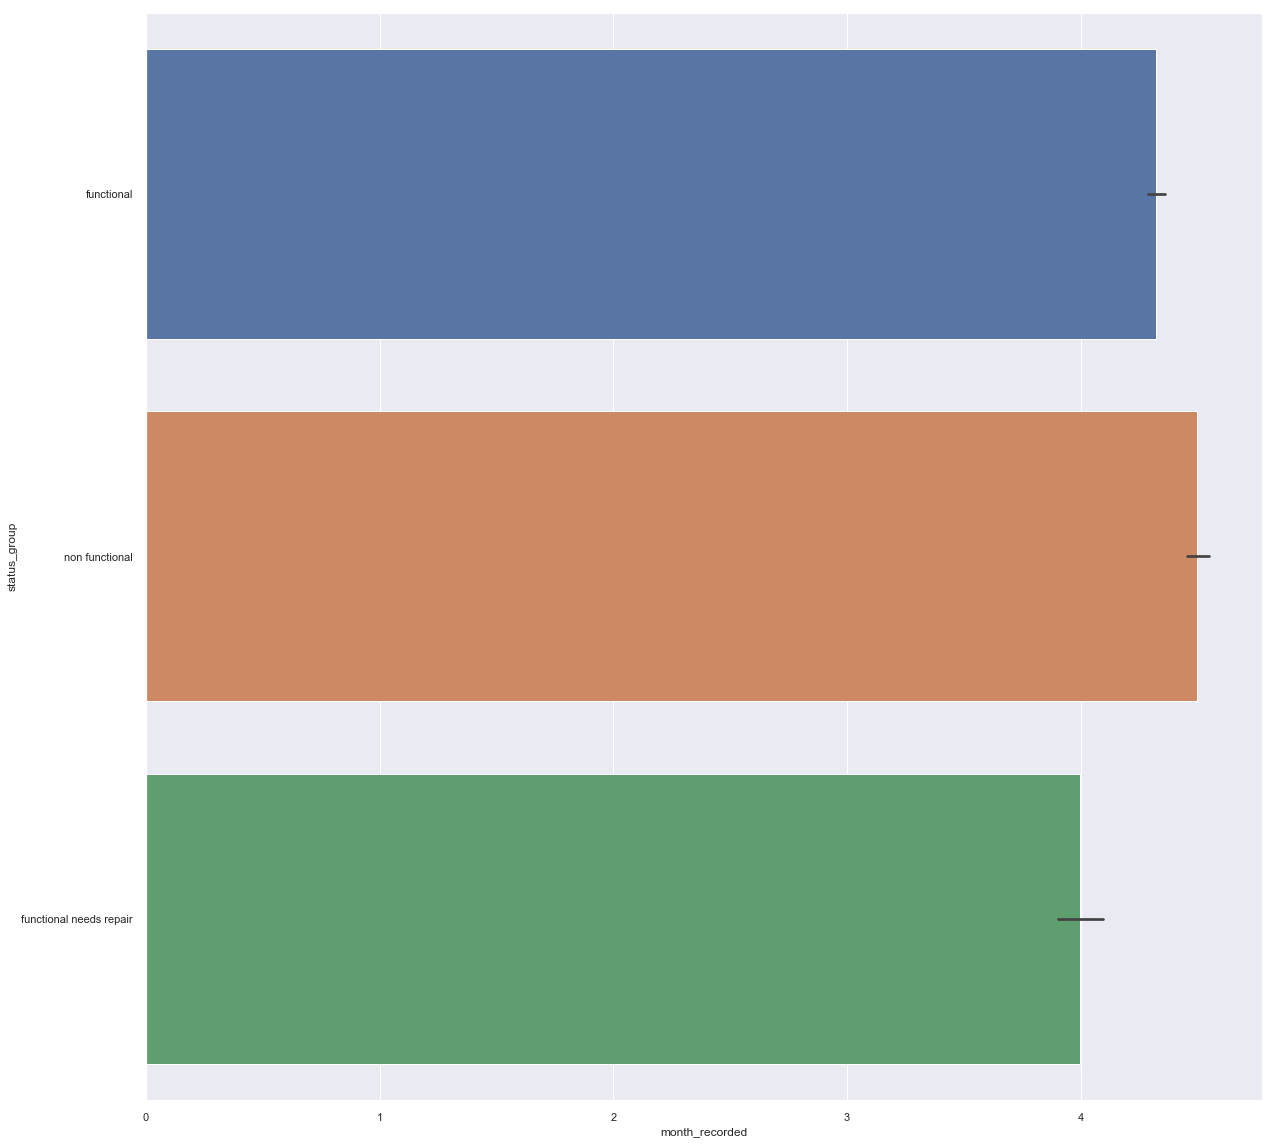

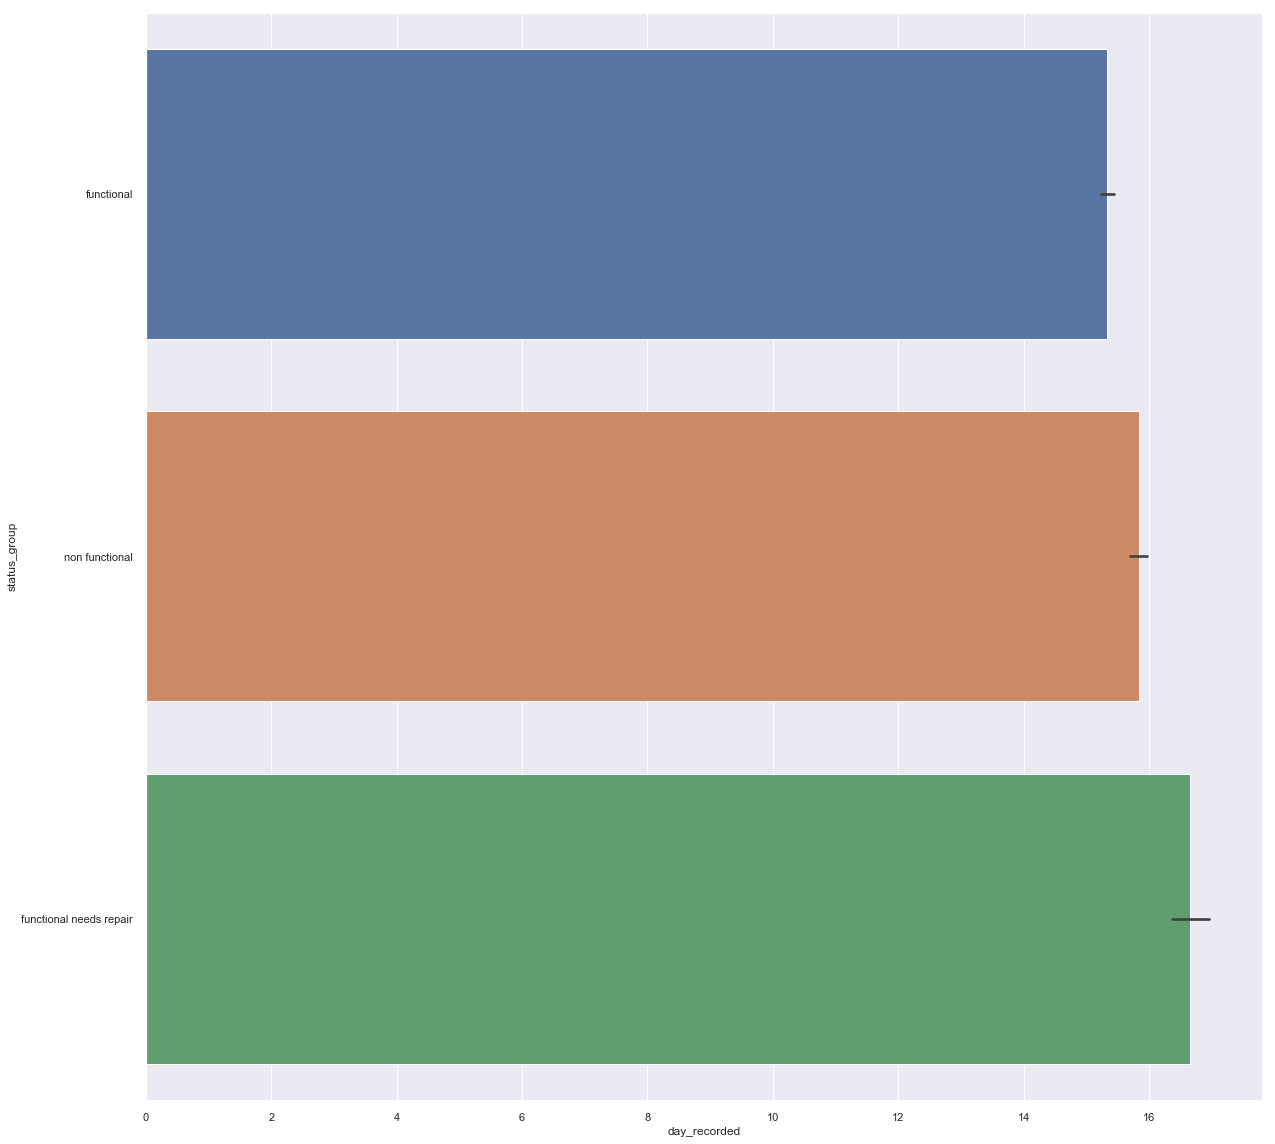

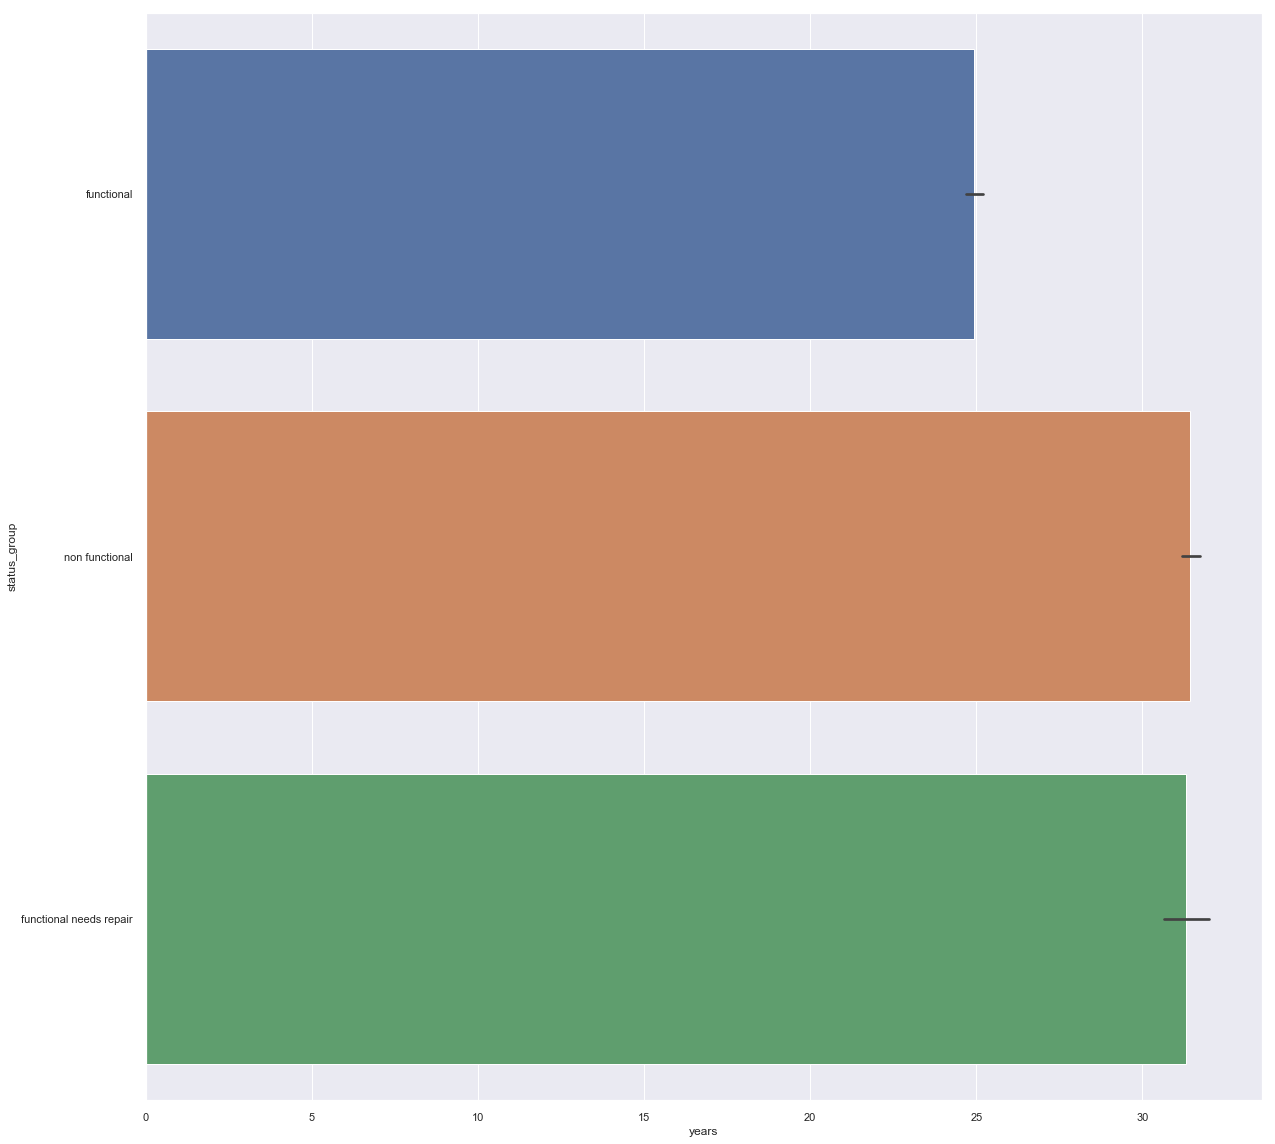

In [98]:
for feature in numeric_features:
    sns.barplot(x=feature, y=target, data=train)
    plt.show()

In [76]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

model = DecisionTreeClassifier(max_depth=20, random_state=42)
model.fit(X_train_scaled, y_train)
print('Train Accuracy', model.score(X_train_scaled, y_train))
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

Train Accuracy 0.8958754208754208
Validation Accuracy 0.7664141414141414


In [77]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth=20, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Validation accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation accuracy 0.7665824915824916


In [78]:
from sklearn.ensemble import RandomForestClassifier

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RobustScaler(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=25, max_depth=None, min_samples_split=20, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Validation accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation accuracy 0.8033670033670034


In [79]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-03.csv', index=False)

In [80]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RobustScaler(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('Validation accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation accuracy 0.8128787878787879


In [81]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-04.csv', index=False)

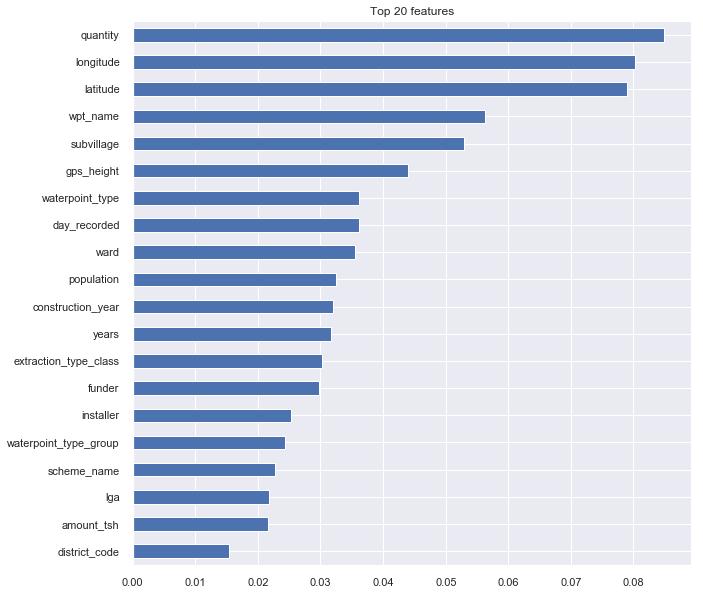

In [93]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 20
plt.figure(figsize=(10,10))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh()
plt.savefig("top_20.png")

In [19]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test
cardinality = train_features.select_dtypes(exclude='number').nunique()
medium_cardinality = cardinality[cardinality <= 50].index.tolist()
high_cardinality = cardinality[cardinality > 50].index.tolist()

pipeline = make_pipeline(
    ce.OneHotEncoder(cols=medium_cardinality),
    ce.OrdinalEncoder(cols=high_cardinality),
    RobustScaler(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('Validation accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation accuracy 0.812037037037037


In [20]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-05.csv', index=False)

In [21]:
#Tried clustering, didn't improve results

from sklearn.cluster import KMeans 

def new_clusters(X):
    X = X.copy()
    lat_lon = np.array(X[['latitude','longitude']])
    kmeans = KMeans(n_clusters=14)
    kmeans.fit(lat_lon)
    labels = kmeans.labels_
    
    X['clusters'] = labels
    X = X.drop(columns=['latitude','longitude'])
    
    return X

In [22]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RobustScaler(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('Validation accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation accuracy 0.8128787878787879


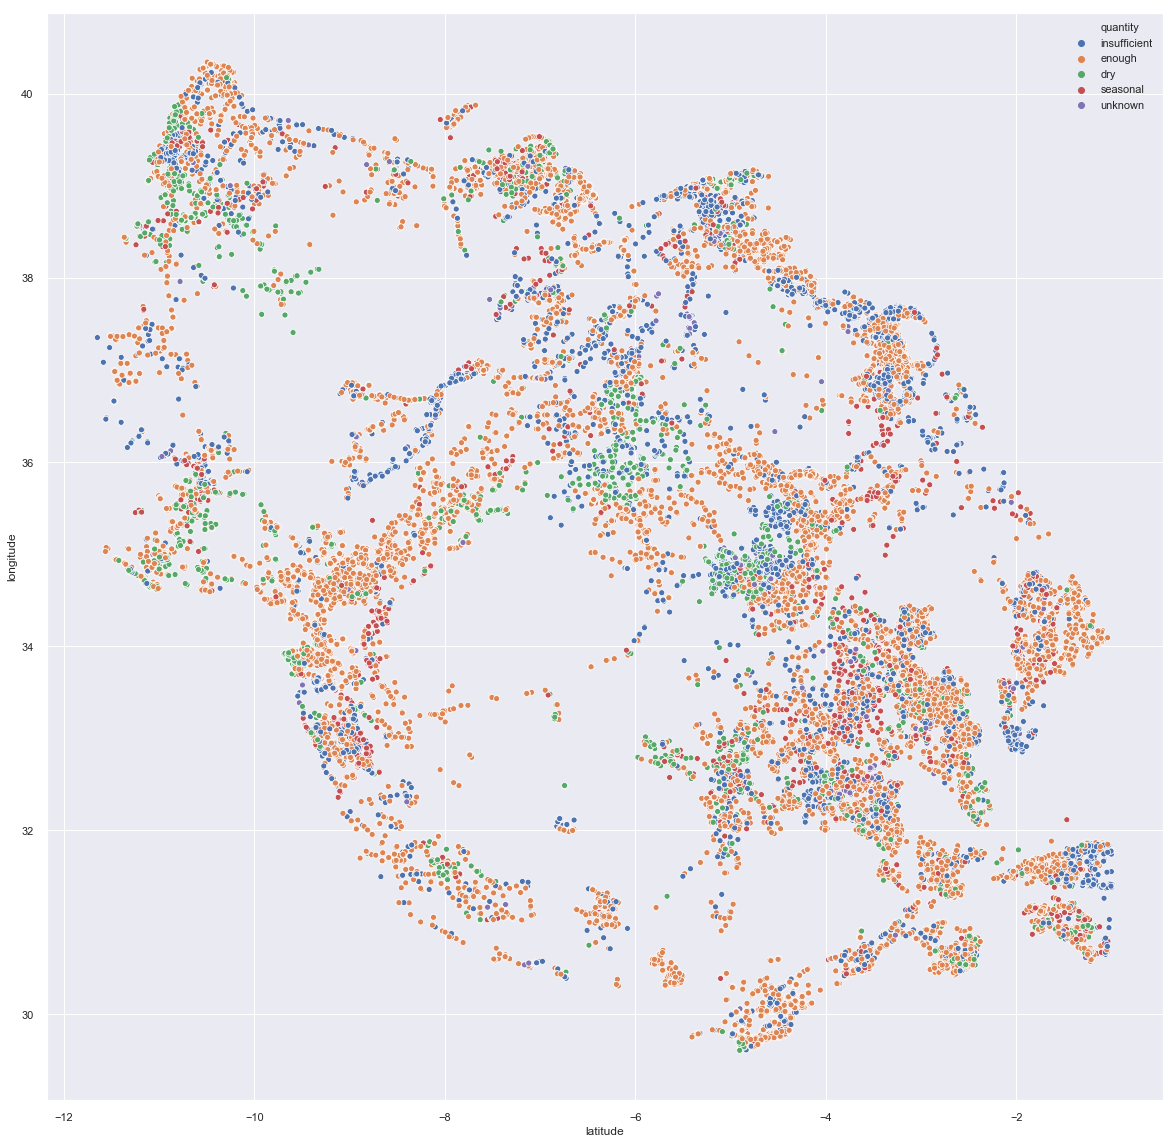

In [58]:
sns.scatterplot(x=train['latitude'],y=train['longitude'],hue=train['quantity'])
sns.set(rc={'figure.figsize':(20,20)})
sns_status_group.figure.savefig("lat_lon_quantity.png")

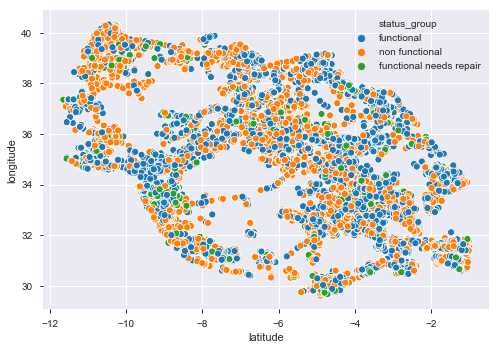

In [24]:
sns.scatterplot(x=train['latitude'],y=train['longitude'],hue=train['status_group']);

In [25]:
from xgboost import XGBClassifier

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# cardinality = train_features.select_dtypes(exclude='number').nunique()
# medium_cardinality = cardinality[cardinality <= 150].index.tolist()
# high_cardinality = cardinality[cardinality > 150].index.tolist()

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RobustScaler(),
    SimpleImputer(strategy='median'),
    XGBClassifier(random_state=45, objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1, verbosity=1,
                      max_depth = 20, colsample_bytree=0.5, colsample_bylevel=0.5, colsample_bynode=0.5)
)

pipeline.fit(X_train, y_train)
print('Validation accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation accuracy 0.8157407407407408


In [26]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

model = XGBClassifier(random_state=45, objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1, verbosity=1,
                      max_depth = 20, colsample_bytree=0.5, colsample_bylevel=0.5, colsample_bynode=0.5)

model.fit(X_train_scaled, y_train)
print('Train Accuracy', model.score(X_train_scaled, y_train))
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

Train Accuracy 0.9955808080808081
Validation Accuracy 0.8157407407407408


In [27]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-06.csv', index=False)

In [28]:
#Tried gridsearch. Takes too long, skipped for now

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(XGBClassifier(),{'max_depth': [1,3,5,10,15,20],
                        'n_estimators': [50,200,500,1000],
                        'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6]},
                        verbose=1)

# clf.fit(X_train_scaled, y_train)

# clf.best_params_

In [29]:
X_train_encode = encoder.fit_transform(train)

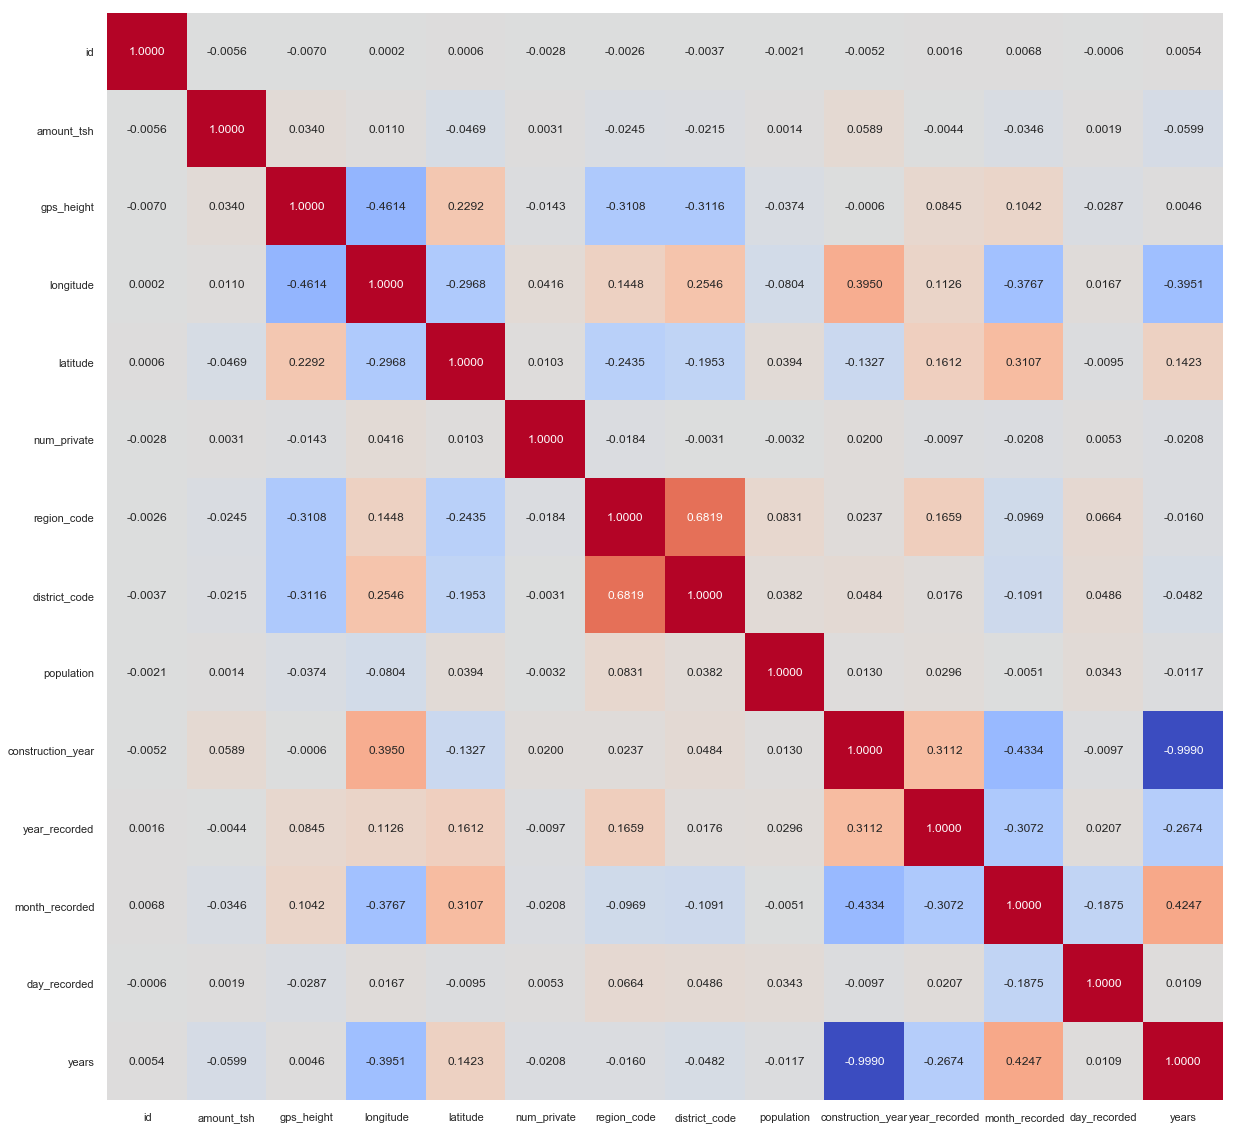

In [55]:
df_encoded = pd.DataFrame(data=train, columns=train.columns)
fig, ax = plt.subplots()
sns.heatmap(df_encoded.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
sns.set(rc={'figure.figsize':(20,20)})
plt.savefig('corr_matrix.png', bbox_inches='tight', pad_inches=0.0)

In [31]:
  def haversine_np(lon1, lat1, lon2, lat2): 
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)

        All args must be of equal length.    

        """
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km

In [32]:
#Distance with Haversine Function

def distance(X):
    X = X.copy()
    distances = X[['id','longitude','latitude']]
    distances =distances.sort_values(by=['longitude','latitude'])
    distances['coords']=distances[['longitude','latitude']].values.tolist()
    
    shift_distances=distances.shift(1).loc[:,'coords' ]
    distances_2 = pd.concat([distances, shift_distances], axis=1)
    distances_2.columns =['id','longitude','latitude','coord_1','coords_2']
    distances_2['long2']=pd.to_numeric(distances_2['coords_2'].str[0])
    distances_2['lat2']=pd.to_numeric(distances_2['coords_2'].str[1])
    distances_2=distances_2.fillna(0)
    
    distances_2['dist'] = distances_2.apply(lambda x: haversine_np(x[1], x[2], x[5], x[6]), axis = 1)
    location=distances_2[['id','dist']]
    X=X.merge(location, left_on='id', right_on='id', how='inner')
    X = X.drop(columns=['id'])
    
    return X

In [33]:
train = pd.merge(pd.read_csv(LOCAL + 'train_features.csv'), 
                 pd.read_csv(LOCAL + 'train_labels.csv'))
test = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [34]:
def wrangle_new(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    X['construction_year'] = X['construction_year'].replace(0, 1960)
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns=['quantity_group','date_recorded', 'recorded_by'])
    
    X['years'] = X['year_recorded'] - X['construction_year'] 
    
    return X

In [35]:
train = wrangle_new(train)
val = wrangle_new(val)
test = wrangle_new(test)

In [36]:
train_h = distance(train)
val_h = distance(val)
test_h = distance(test)

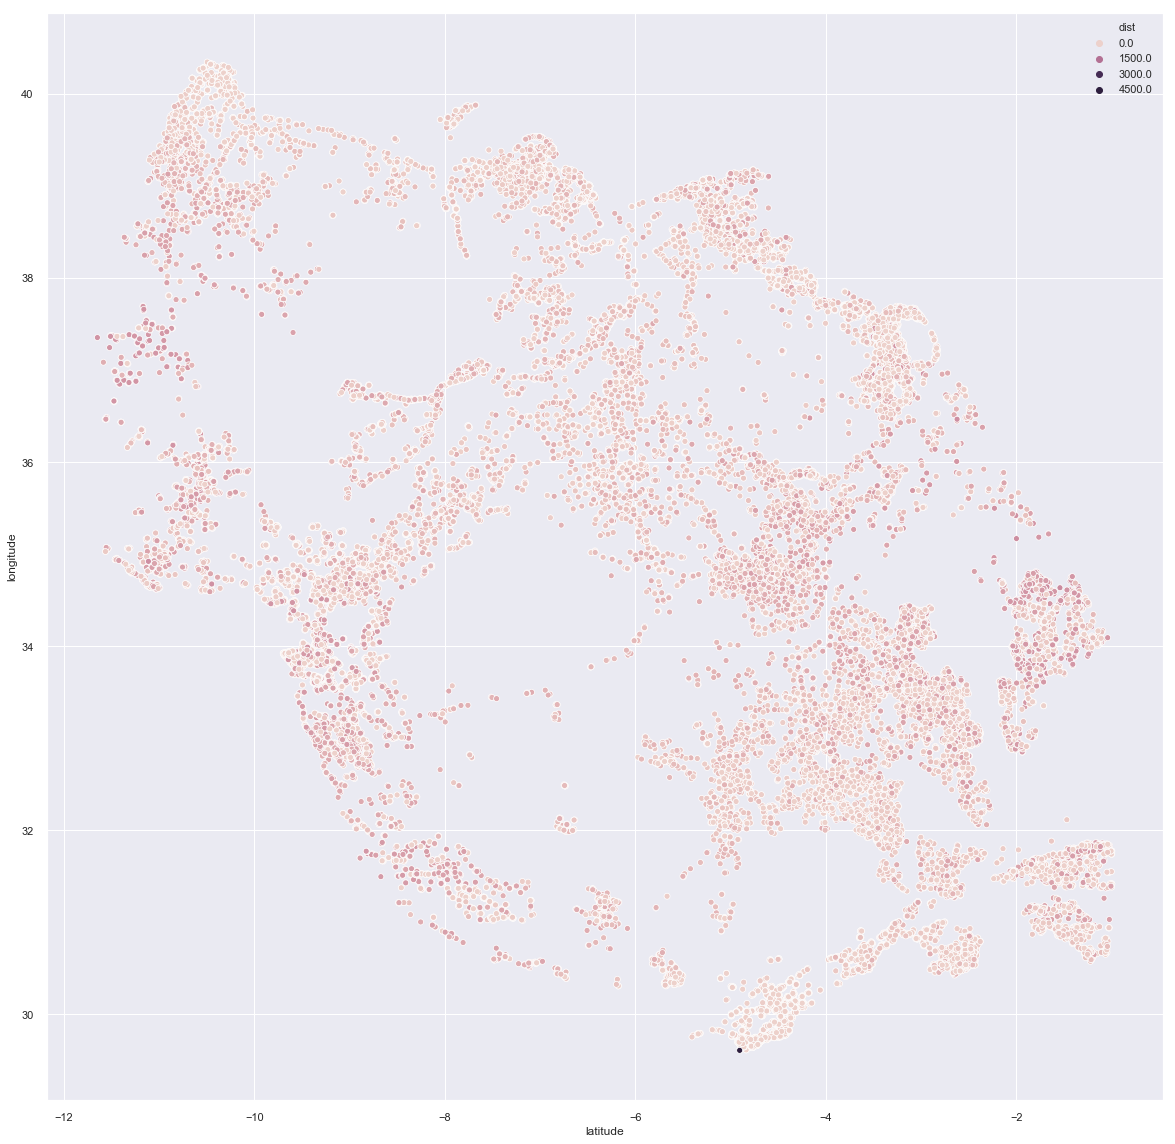

In [57]:
sns.scatterplot(x=train_h['latitude'],y=train_h['longitude'],hue=train_h['dist'])
sns.set(rc={'figure.figsize':(20,20)})
sns_status_group.figure.savefig("lat_lon_dist.png")

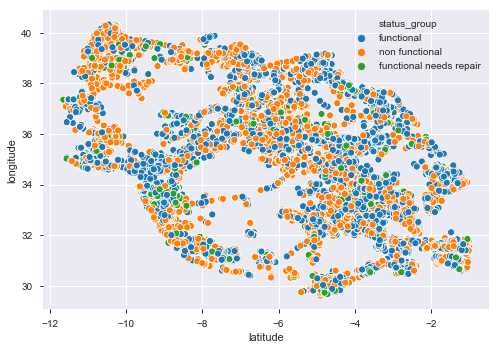

In [38]:
sns.scatterplot(x=train_h['latitude'],y=train_h['longitude'],hue=train_h['status_group']);

In [39]:
train_h['region'].value_counts()

Iringa           4250
Shinyanga        3972
Mbeya            3703
Kilimanjaro      3512
Morogoro         3238
Arusha           2686
Kagera           2615
Mwanza           2485
Kigoma           2276
Pwani            2110
Ruvuma           2090
Tanga            2029
Dodoma           1768
Singida          1678
Tabora           1586
Mara             1560
Rukwa            1440
Mtwara           1384
Manyara          1284
Lindi            1223
Dar es Salaam     631
Name: region, dtype: int64

In [40]:
def population_region(row):
    if row['region'] == 'Iringa':
        val = 941238
    elif row['region'] == 'Shinyanga':
        val = 1534808
    elif row['region'] == 'Mbeya':
        val = 2707410
    elif row['region'] == 'Kilimanjaro':
        val = 1640087
    elif row['region'] == 'Morogoro':
        val = 2218492
    elif row['region'] == 'Arusha':
        val = 1694310
    elif row['region'] == 'Kagera':
        val = 2458023
    elif row['region'] == 'Mwanza':
        val = 2772509
    elif row['region'] == 'Kigoma':
        val = 2127930
    elif row['region'] == 'Pwani':
        val = 1098668
    elif row['region'] == 'Ruvuma':
        val = 1376891
    elif row['region'] == 'Tanga':
        val = 2045205
    elif row['region'] == 'Dodoma':
        val = 2083588
    elif row['region'] == 'Singida':
        val = 1370637
    elif row['region'] == 'Tabora':
        val = 2291623
    elif row['region'] == 'Mara':
        val = 1743830
    elif row['region'] == 'Rukwa':
        val = 1004539
    elif row['region'] == 'Mtwara':
        val = 1270854
    elif row['region'] == 'Manyara':
        val = 1425131
    elif row['region'] == 'Lindi':
        val = 864652
    elif row['region'] == 'Dar es Salaam':
        val = 4364541
    else:
        val = 0
    return val

In [41]:
train_h['population_region'] = train_h.apply(population_region, axis=1)
val_h['population_region'] = val_h.apply(population_region, axis=1)
test_h['population_region'] = test_h.apply(population_region, axis=1)


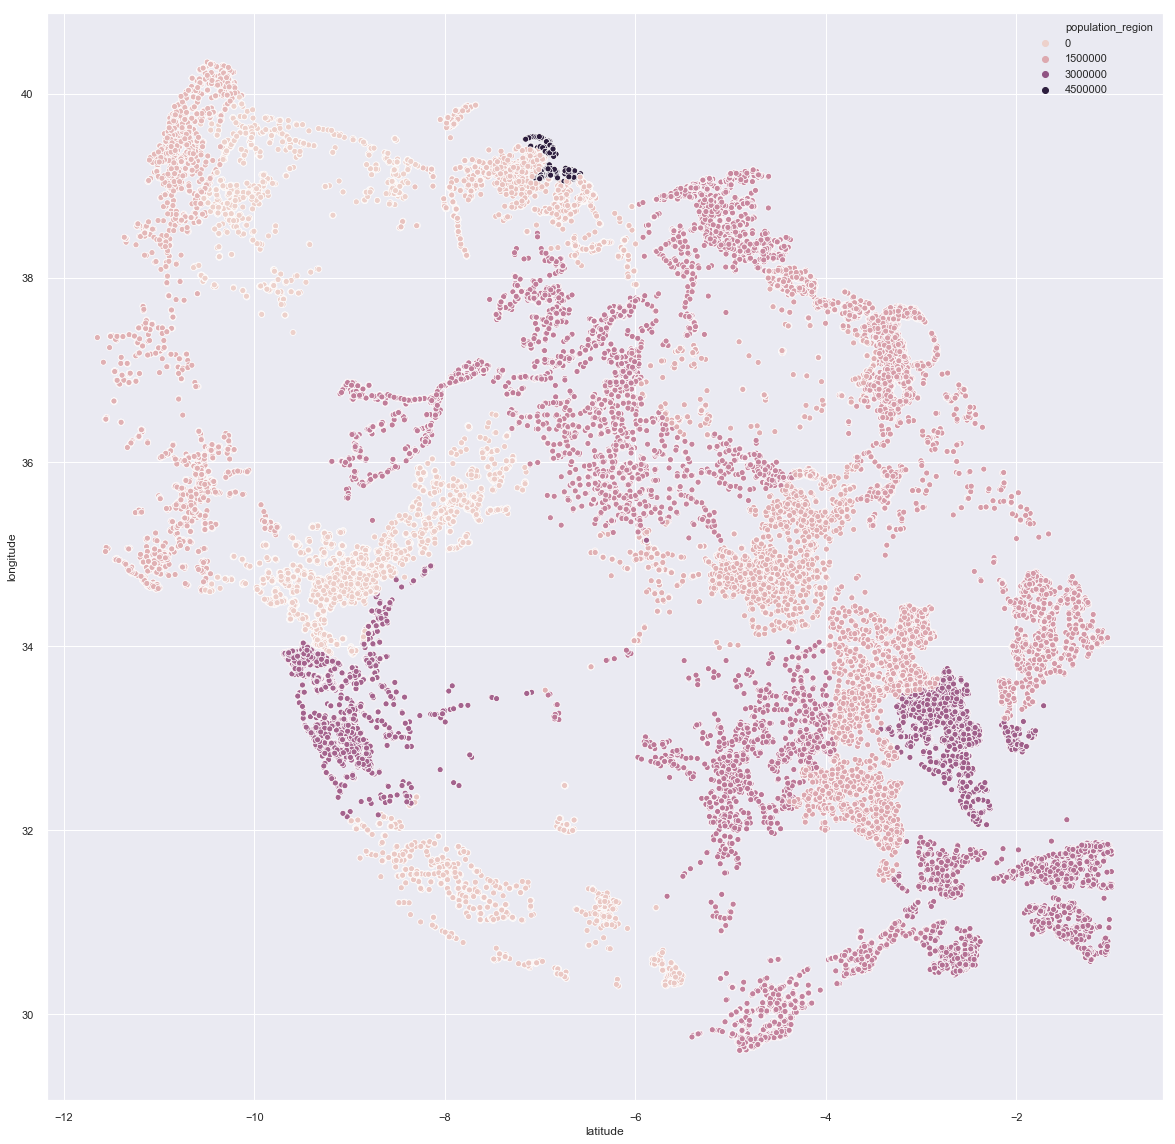

In [56]:
sns.scatterplot(x=train_h['latitude'],y=train_h['longitude'],hue=train_h['population_region'])
sns.set(rc={'figure.figsize':(20,20)})
sns_status_group.figure.savefig("lat_lon_pop_region.png")

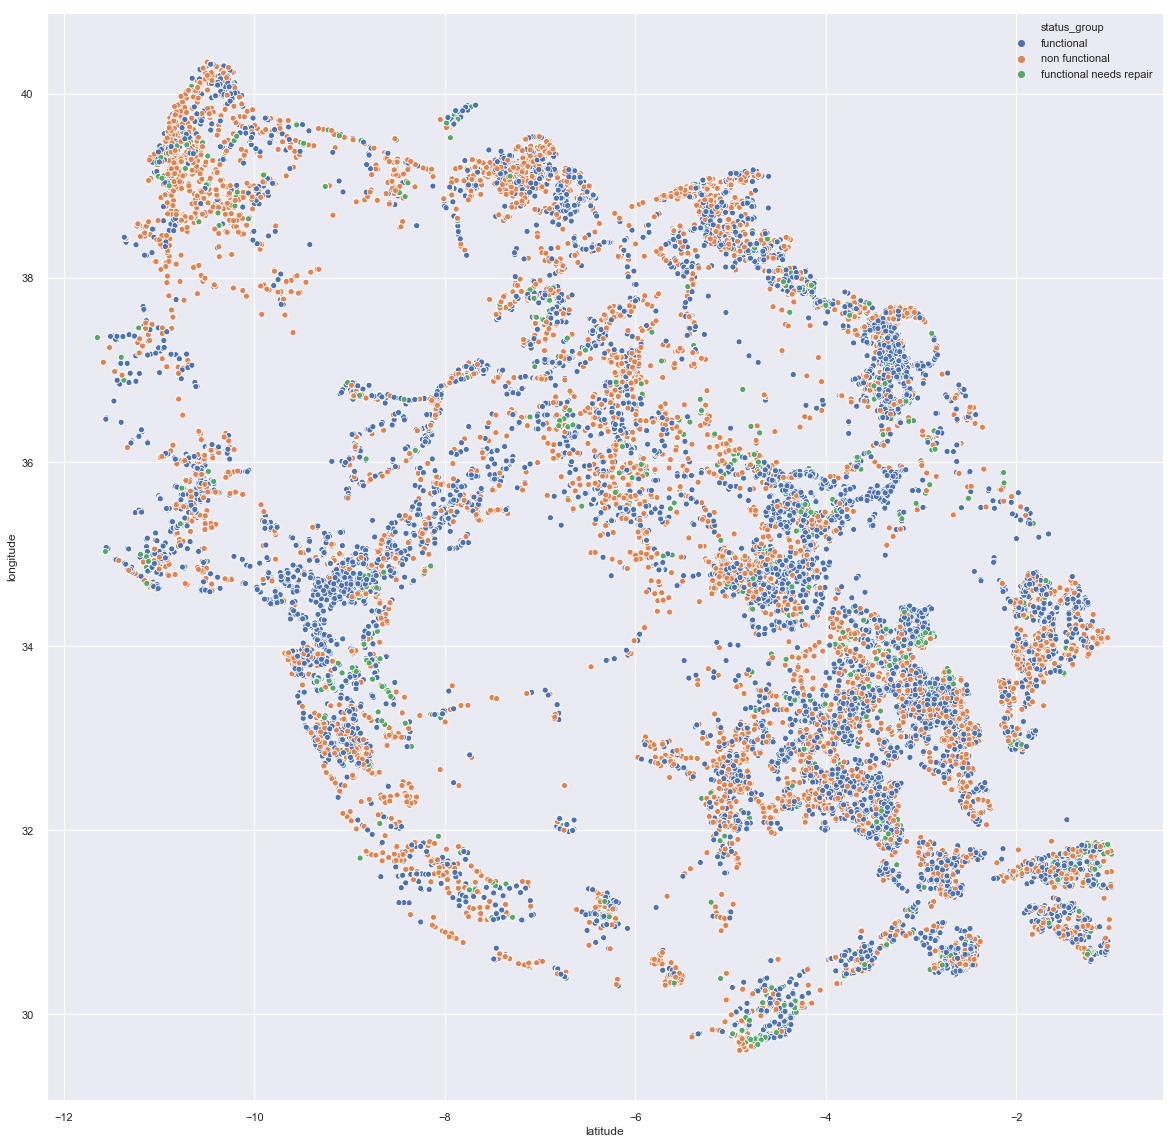

In [95]:
sns_status_group = sns.scatterplot(x=train_h['latitude'],y=train_h['longitude'],hue=train_h['status_group'])
sns.set(rc={'figure.figsize':(20,20)})
sns_status_group.figure.savefig("lat_lon_status.png")

In [173]:
X_train = train_h.drop(columns=[target,'population'])
y_train = train_h[target]
X_val = val_h.drop(columns=[target,'population'])
y_val = val_h[target]
X_test = test

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

model = XGBClassifier(random_state=45, objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1, verbosity=1,
                      max_depth = 20, colsample_bytree=0.5, colsample_bylevel=0.5, colsample_bynode=0.5)

model.fit(X_train_scaled, y_train)
print('Train Accuracy', model.score(X_train_scaled, y_train))
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

Train Accuracy 0.9984217171717171
Validation Accuracy 0.8128787878787879


## Worked on blog post

Link to draft: https://medium.com/@nayomichibana/data-science-for-social-good-predicting-faulty-water-pumps-in-tanzania-eb5663544f96